## Step 1 — Colab setup & load data

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler
from scipy.cluster import hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

In [2]:
df = pd.read_csv('Wholesale customers data.csv')
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [3]:
display(df.info())
print('\n',  df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


None


 (440, 8)


In [4]:
display(df.describe(), round(2))

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


2

In [5]:
print("\n Missing values per column: \n", df.isnull().sum())


 Missing values per column: 
 Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64


In [6]:
print("\n Unique Values (Channel, Regiopn): ")
print("Channel:", df['Channel'].unique())
print("Region:", df['Region'].unique())


 Unique Values (Channel, Regiopn): 
Channel: [2 1]
Region: [3 1 2]


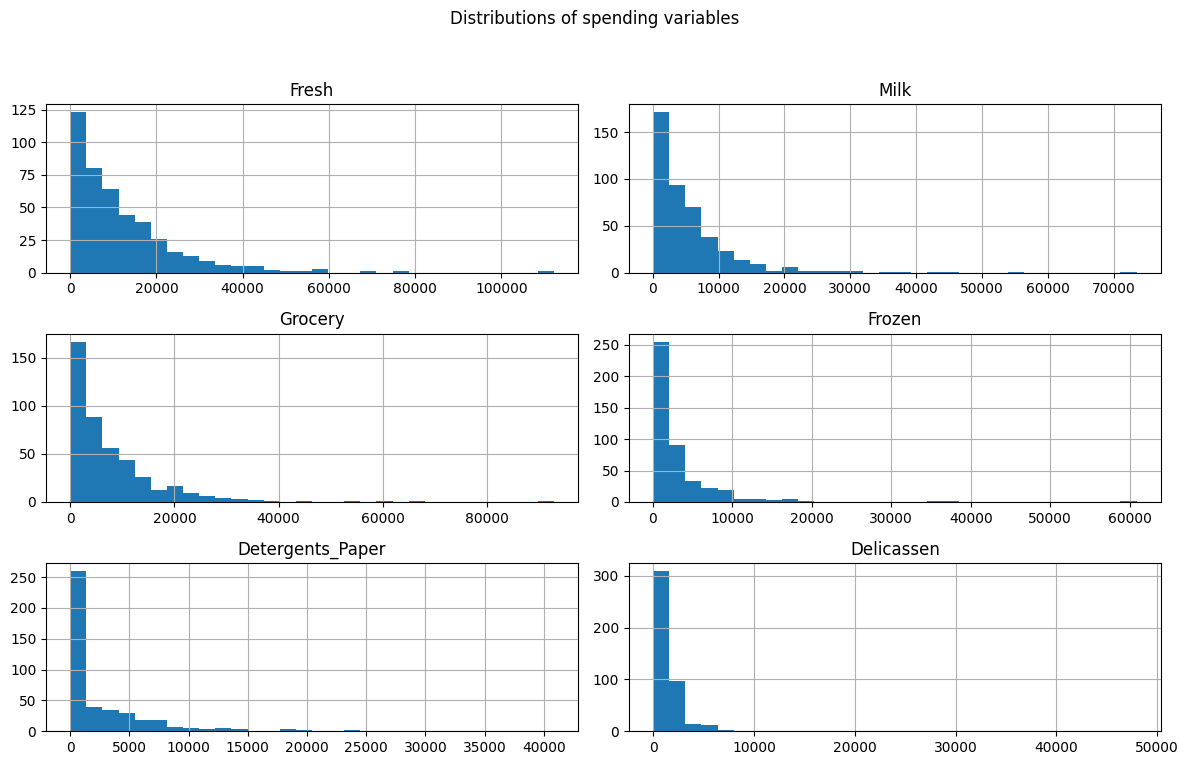

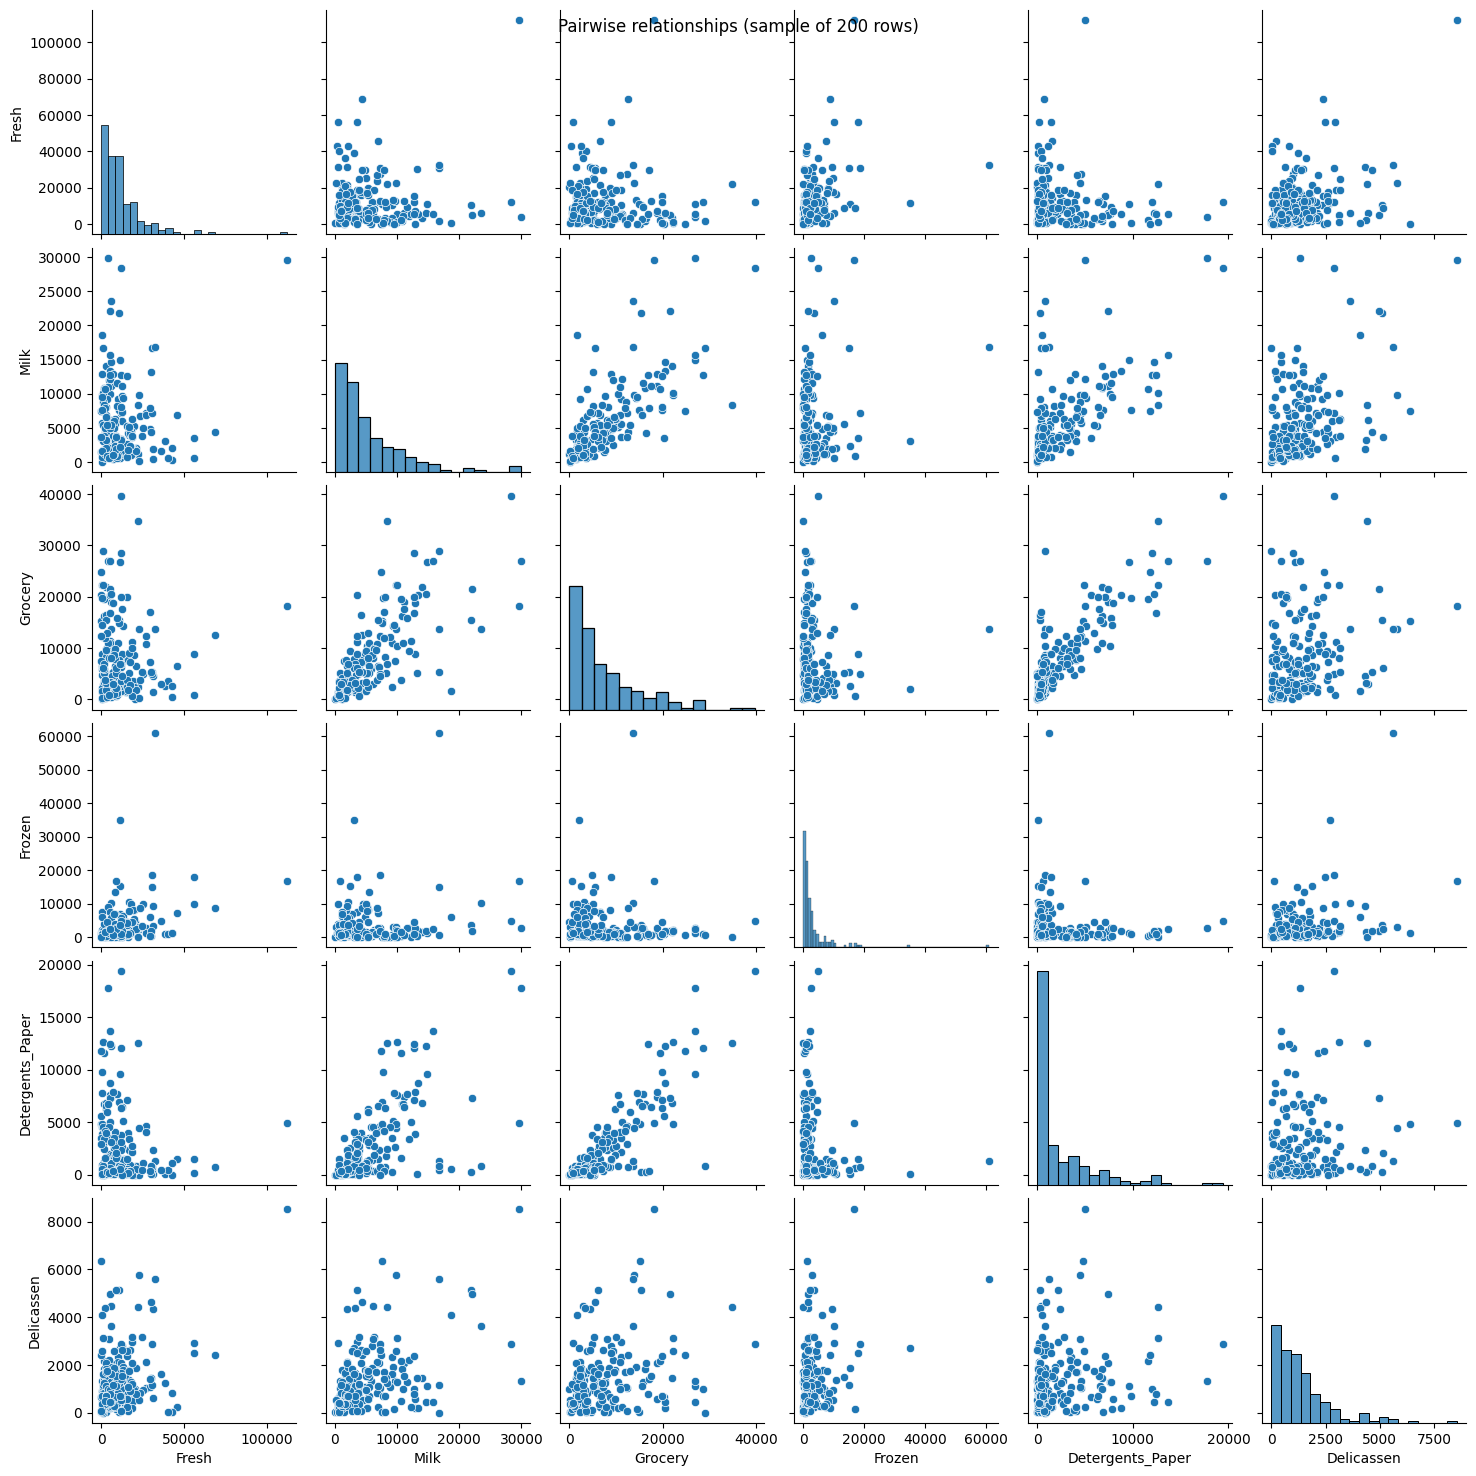

In [7]:
# Histogram grid for the spending columns
spending_cols = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
df[spending_cols].hist(bins=30, figsize=(12,8))
plt.suptitle("Distributions of spending variables")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Pairwise scatter (small sample to keep it quick)
sns.pairplot(df[spending_cols].sample(200, random_state=42))
plt.suptitle("Pairwise relationships (sample of 200 rows)")
plt.show()

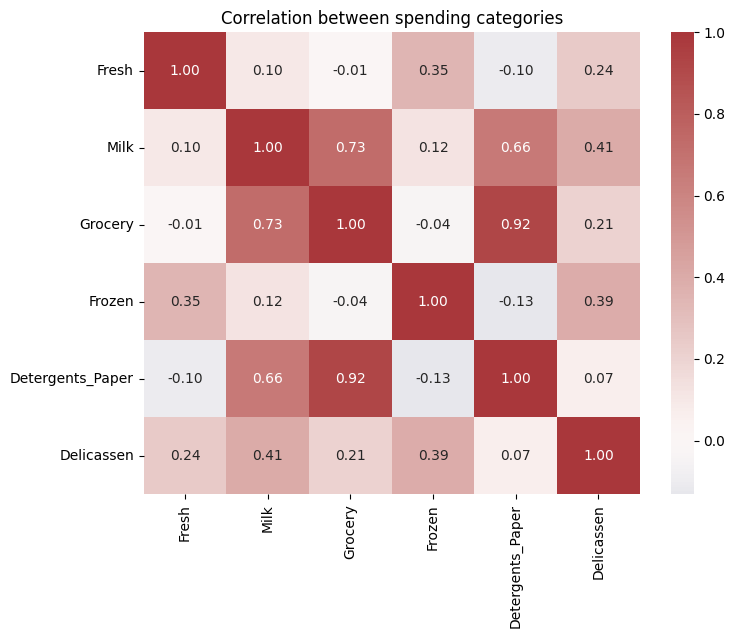

In [8]:
# --- Cell 5: Quick correlation heatmap ---
plt.figure(figsize=(8,6))
sns.heatmap(df[spending_cols].corr(), annot=True, fmt=".2f", cmap="vlag", center=0)
plt.title("Correlation between spending categories")
plt.show()

## Step 2 — Preprocessing + Dendrogram (Ward Linkage)yyy6

In [9]:
spending_cols = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
X = df[spending_cols].copy()

X.skew().round(2)

,0
Fresh,2.56
Milk,4.05
Grocery,3.59
Frozen,5.91
Detergents_Paper,3.63
Delicassen,11.15


In [10]:
X_log = np.log1p(X)

print("Skew after log-transform:")
print(pd.DataFrame({
    "before": X.skew(),
    "after": pd.DataFrame(X_log).skew()
}).round(2 ))

Skew after log-transform:
                  before  after
Fresh               2.56  -1.58
Milk                4.05  -0.22
Grocery             3.59  -0.67
Frozen              5.91  -0.35
Detergents_Paper    3.63  -0.24
Delicassen         11.15  -1.09


In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)

print("Shape after scaling:", X_scaled.shape)

Shape after scaling: (440, 6)


In [12]:
from scipy.cluster.hierarchy import linkage

Z = linkage(X_scaled, method='ward')
print("Linkage matrix shape:", Z.shape)

Linkage matrix shape: (439, 4)


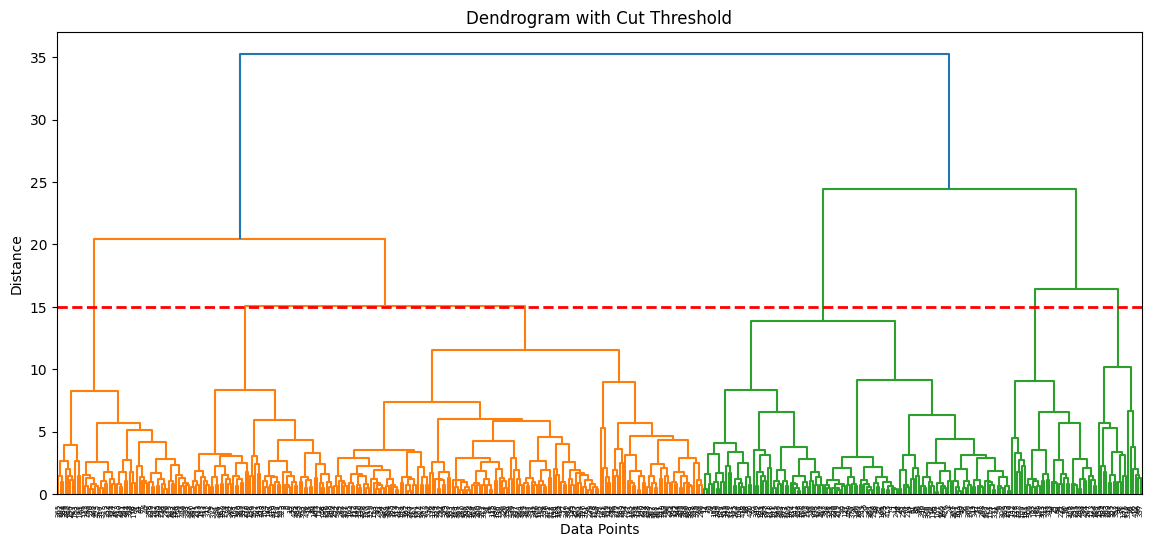

In [13]:
plt.figure(figsize=(14, 6))
dendrogram = sch.dendrogram(Z)
plt.axhline(y=15, color='red', linestyle='--', linewidth=2)
plt.title("Dendrogram with Cut Threshold")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()


## Step 3 — Fit Agglomerative Clustering & Cluster Analysis

In [14]:
k = 4

In [15]:
from sklearn.cluster import AgglomerativeClustering

hc = AgglomerativeClustering(
    n_clusters=k,
    metric='euclidean',
    linkage='ward'
)

cluster_labels = hc.fit_predict(X_scaled)
cluster_labels[:10]

array([2, 2, 2, 3, 3, 2, 1, 2, 1, 2])

In [16]:
df_clusters = df.copy()
df_clusters['Cluster'] = cluster_labels
df_clusters.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Cluster
0,2,3,12669,9656,7561,214,2674,1338,2
1,2,3,7057,9810,9568,1762,3293,1776,2
2,2,3,6353,8808,7684,2405,3516,7844,2
3,1,3,13265,1196,4221,6404,507,1788,3
4,2,3,22615,5410,7198,3915,1777,5185,3


In [17]:
df_clusters['Cluster'].value_counts().sort_index()

,count
Cluster,
0,53
1,208
2,125
3,54


In [18]:
cluster_profile = df_clusters.groupby('Cluster')[spending_cols].mean().round(1)
cluster_profile

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Cluster,,,,,,
0,3914.0,5223.0,8657.9,1198.4,3474.1,190.5
1,12025.6,2279.8,2880.6,2493.2,538.8,882.2
2,9107.8,11083.0,16616.9,1527.3,7377.0,2032.2
3,26534.9,7665.9,6729.8,10715.5,917.3,4135.5


In [19]:
cluster_profile_scaled = df_clusters.groupby('Cluster')[spending_cols].mean()
cluster_profile_scaled = np.log1p(cluster_profile_scaled)       # same transform as input
cluster_profile_scaled = pd.DataFrame(scaler.transform(cluster_profile_scaled),
                                      columns=spending_cols)

cluster_profile_scaled.round(2)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,-0.31,0.41,0.56,-0.17,0.80,-1.10
1,0.45,-0.36,-0.43,0.41,-0.29,0.09
2,0.26,1.10,1.15,0.02,1.24,0.73
3,0.99,0.76,0.34,1.54,0.02,1.28


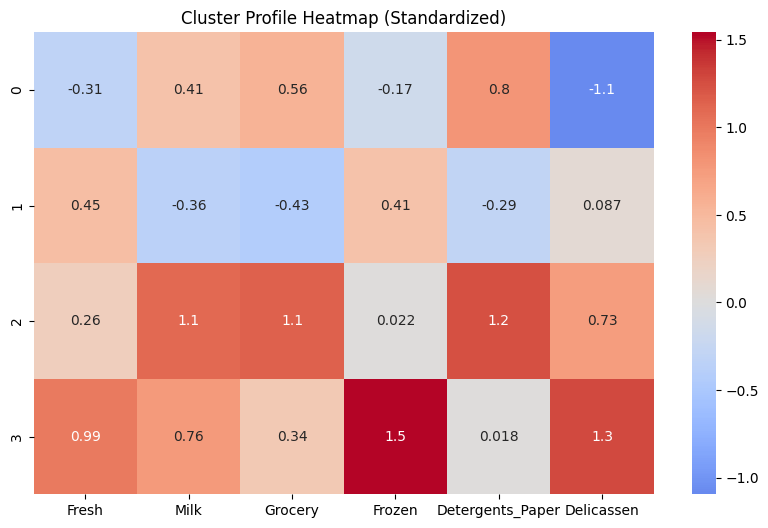

In [20]:
plt.figure(figsize=(10,6))
sns.heatmap(cluster_profile_scaled, annot=True, cmap="coolwarm", center=0)
plt.title("Cluster Profile Heatmap (Standardized)")
plt.show()

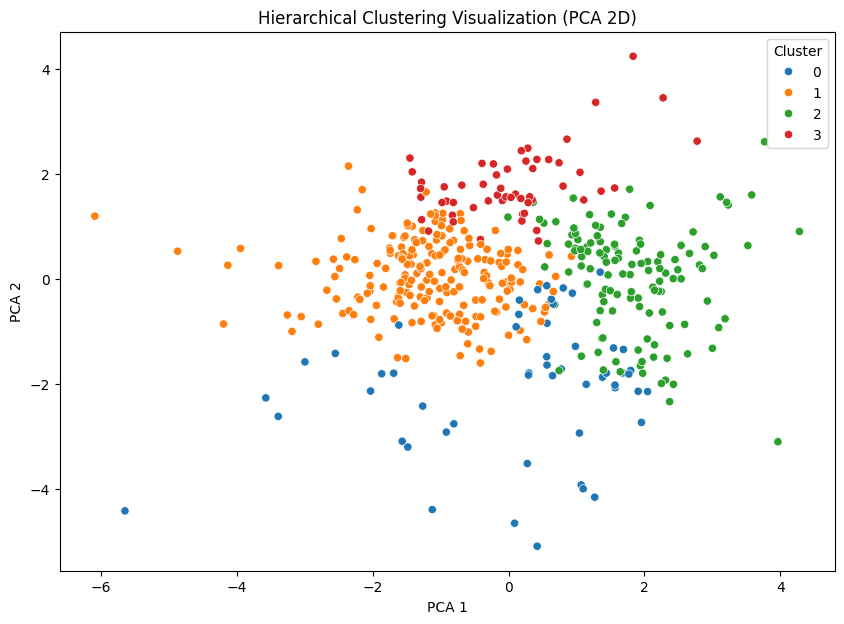

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,7))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=cluster_labels, palette='tab10')
plt.title("Hierarchical Clustering Visualization (PCA 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title='Cluster')
plt.show()

In [22]:
cluster_profile


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Cluster,,,,,,
0,3914.0,5223.0,8657.9,1198.4,3474.1,190.5
1,12025.6,2279.8,2880.6,2493.2,538.8,882.2
2,9107.8,11083.0,16616.9,1527.3,7377.0,2032.2
3,26534.9,7665.9,6729.8,10715.5,917.3,4135.5


Using hierarchical clustering, I identified 4 distinct customer segments within the wholesale dataset.

- Cluster 0 consists of large multi-category buyers, likely supermarkets or large retailers.

- Cluster 1 includes Fresh and Frozen–focused customers such as hotels and restaurants.

- Cluster 2 represents low-volume customers with limited spending across categories.

- Cluster 3 specializes in Detergents and Grocery purchases, indicating cleaning businesses or dry-goods retailers.

These clusters provide actionable segmentation insights that can help wholesale distributors design targeted marketing strategies, price packages, and customer retention programs.